In [333]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output

from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ncair-2023-ai-competition/sample_submission.csv
/kaggle/input/ncair-2023-ai-competition/data_description.txt
/kaggle/input/ncair-2023-ai-competition/train.csv
/kaggle/input/ncair-2023-ai-competition/test.csv


In [334]:
test_fp = '/kaggle/input/ncair-2023-ai-competition/test.csv' 
train_fp = '/kaggle/input/ncair-2023-ai-competition/train.csv'

#LAODING THE DATASET FOR TRAINING AND TESTING
df_train = pd.read_csv(train_fp,index_col='BVN') # training data
df_test = pd.read_csv(test_fp,index_col='BVN') # testing data

In [335]:
df_train.dropna(subset=['EDUCATION'], inplace=True)

In [336]:
#df_train['DOB'] = pd.to_datetime(df_train['DOB'], format='%m/%d/%Y')

# convert the date column to a datetime dtype, matching the different formats
#df_train['DOB'] = pd.to_datetime(df_train['DOB'], format='%m/%dd/%YYYY', errors='coerce')
# df_train['DOB'] = pd.to_datetime(df_train['DOB'], format='%Y/%m/%d', errors='coerce')
# df_train['DOB'] = pd.to_datetime(df_train['DOB'], format='%Y-%m-%d', errors='coerce')
# df_train['DOB'] = pd.to_datetime(df_train['DOB'], format='%Y%m%d', errors='coerce')

In [337]:
if 0 in df_train['MARRIAGE'].values:
    df_train = df_train[df_train['MARRIAGE'] != 0]

In [338]:
df_train 

,LIMIT_BAL,SEX,DOB,Nationality,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
BVN,,,,,,,,,,,,,,,,,,,,,
14814386054,130000,Female,2/8/1986,Nigeria,Undergraduate,Single,0,0,0,0,...,122870,120373,134146,4100,20000,6000,5000,20000,6000,0
13236658884,20000,Female,2/8/1981,Nigeria,Uneducated,Single,-1,-1,-1,-1,...,7312,1868,1470,637,11869,7314,2274,1470,2200,0
65056270987,110000,Male,3/5/1997,Nigeria,Undergraduate,Married,2,0,0,0,...,43581,48458,17129,3000,10000,5000,6000,0,2000,0
13844999415,120000,Female,4/9/1980,Nigeria,Undergraduate,Divorce,0,0,0,0,...,49272,49016,43127,1856,1667,1632,1664,1880,1059,0
19387743446,20000,Male,8/8/1994,Nigeria,Uneducated,Single,0,0,0,0,...,17850,17737,27240,2000,1354,2113,1000,1000,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16059220456,90000,Male,7/20/1998,Nigeria,Undergraduate,Married,0,0,0,0,...,52285,46430,47404,3453,3868,1960,1658,1718,2200,0
32426551584,220000,Male,9/28/1982,Nigeria,Undergraduate,Single,-1,-1,-1,-1,...,1759,1824,7022,6643,5924,1759,1824,7022,2515,0
32544374668,320000,Male,3/21/1986,Nigeria,Undergraduate,Single,0,0,0,0,...,172200,164032,165857,6496,6343,6003,5967,6525,5167,0


In [339]:
from sklearn.preprocessing import LabelEncoder

CATEGORICAL_COLUMNS = ['SEX', 'MARRIAGE', 'EDUCATION', 'Nationality']
NUMERIC_COLUMNS = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                  'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                  'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','LIMIT_BAL']

for column in CATEGORICAL_COLUMNS:
  df_train[column] = df_train[column].astype('category').cat.codes


In [340]:
from datetime import datetime

df_train['DOB'] = pd.to_datetime(df_train['DOB'], errors='coerce')

current_date = pd.Timestamp.now()
df_train['DOB'] = (current_date - df_train['DOB']).astype('<m8[Y]')

In [341]:
df_train['DOB']=df_train['DOB'].fillna(0).astype(int)

In [342]:
df_train

,LIMIT_BAL,SEX,DOB,Nationality,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
BVN,,,,,,,,,,,,,,,,,,,,,
14814386054,130000,0,37,0,3,3,0,0,0,0,...,122870,120373,134146,4100,20000,6000,5000,20000,6000,0
13236658884,20000,0,42,0,4,3,-1,-1,-1,-1,...,7312,1868,1470,637,11869,7314,2274,1470,2200,0
65056270987,110000,1,26,0,3,2,2,0,0,0,...,43581,48458,17129,3000,10000,5000,6000,0,2000,0
13844999415,120000,0,43,0,3,1,0,0,0,0,...,49272,49016,43127,1856,1667,1632,1664,1880,1059,0
19387743446,20000,1,28,0,4,3,0,0,0,0,...,17850,17737,27240,2000,1354,2113,1000,1000,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16059220456,90000,1,24,0,3,2,0,0,0,0,...,52285,46430,47404,3453,3868,1960,1658,1718,2200,0
32426551584,220000,1,40,0,3,3,-1,-1,-1,-1,...,1759,1824,7022,6643,5924,1759,1824,7022,2515,0
32544374668,320000,1,37,0,3,3,0,0,0,0,...,172200,164032,165857,6496,6343,6003,5967,6525,5167,0


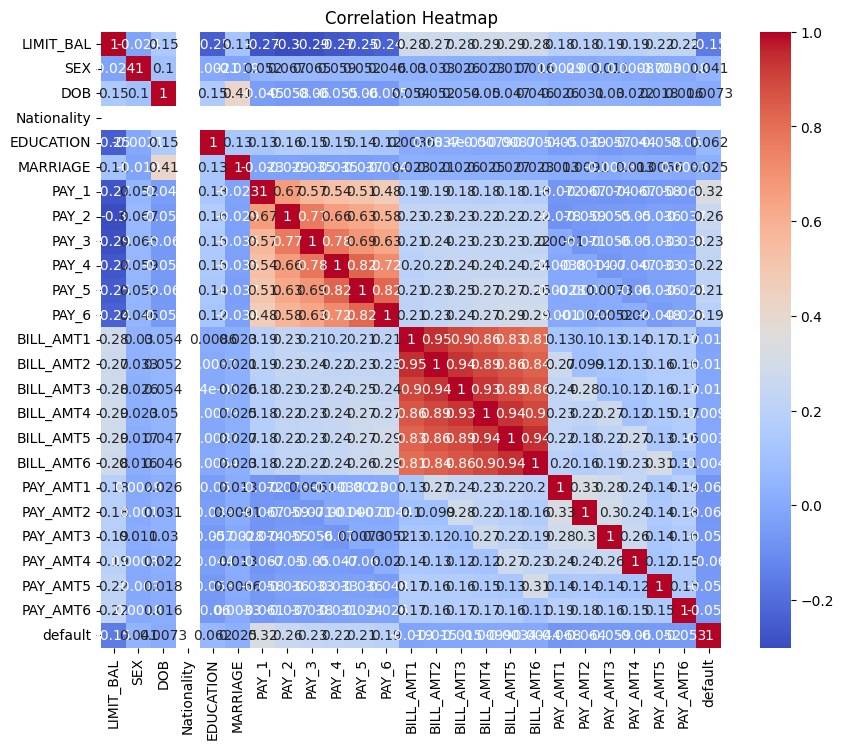

In [343]:
import matplotlib.pyplot as plt

correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [344]:
#df_train = df_train.drop(columns=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])
df_train = df_train.drop(columns=['DOB','SEX','EDUCATION','Nationality'])

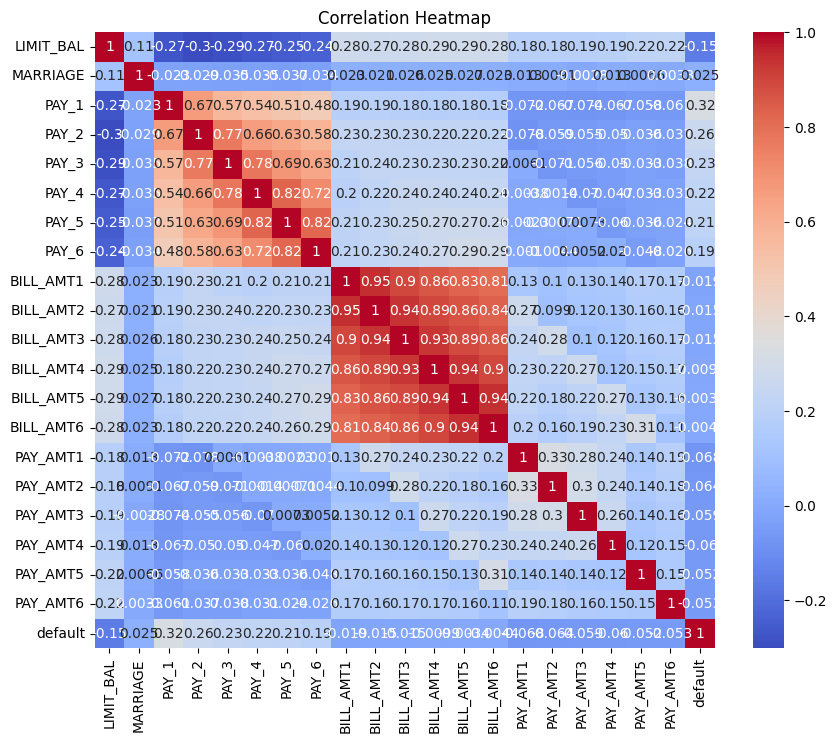

In [345]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [346]:
from sklearn.model_selection import train_test_split
#SPLIT INTO X AND Y
x= df_train.drop('default',axis=1)
y=df_train['default']

#train_features, test_features, train_labels, test_labels = train_test_split(df_train[feature_columns], df_train['default'], test_size=0.2)

In [369]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5,shuffle=1000)


In [348]:
# Create normalized data layer
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

In [349]:
def binary_step(x):
    return tf.where(x < 0, 0, 1)

In [350]:
from tensorflow.keras.layers import Dropout

normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

model = keras.Sequential([
    normalizer,
    layers.Dense(256, activation='relu', input_shape=(25,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(),'accuracy'])

model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliza  (None, 20)               41        
 tion)                                                           
                                                                 
 dense_47 (Dense)            (None, 256)               5376      
                                                                 
 dense_48 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                     

In [351]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [370]:
model.fit(x_train, y_train, 
          batch_size=64, 
          epochs=10, 
          shuffle=1000, 
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/10
132/132 [==============================] - 1s 5ms/step - loss: 0.4243 - auc_10: 0.7851 - accuracy: 0.8212 - val_loss: 0.4247 - val_auc_10: 0.7920 - val_accuracy: 0.8239
Epoch 2/10
132/132 [==============================] - 1s 5ms/step - loss: 0.4200 - auc_10: 0.7923 - accuracy: 0.8255 - val_loss: 0.4282 - val_auc_10: 0.7908 - val_accuracy: 0.8181
Epoch 3/10
132/132 [==============================] - 1s 6ms/step - loss: 0.4171 - auc_10: 0.7973 - accuracy: 0.8212 - val_loss: 0.4267 - val_auc_10: 0.7896 - val_accuracy: 0.8218
Epoch 4/10
132/132 [==============================] - 1s 5ms/step - loss: 0.4148 - auc_10: 0.7973 - accuracy: 0.8269 - val_loss: 0.4332 - val_auc_10: 0.7804 - val_accuracy: 0.8197


In [353]:
from sklearn.linear_model import LogisticRegression


In [354]:
for column in CATEGORICAL_COLUMNS:
  df_test[column] = df_test[column].astype('category').cat.codes

#df_test = df_test.drop(columns=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])


In [355]:
from datetime import datetime
df_test['DOB'] = pd.to_datetime(df_test['DOB'], errors='coerce')

current_date = pd.Timestamp.now()
df_test['DOB'] = (current_date - df_test['DOB']).astype('<m8[Y]')

In [356]:
df_test['DOB']=df_test['DOB'].fillna(0).astype(int)

In [357]:
df_test = df_test.drop(columns=['DOB','SEX','EDUCATION','Nationality'])

In [358]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# y_pred = clf.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# print('Accuracy: {:.2f}'.format(accuracy))
# print('Precision: {:.2f}'.format(precision))
# print('Recall: {:.2f}'.format(recall))
# print('F1-score: {:.2f}'.format(f1))

In [371]:
def make_predictions(model, test_data):
    # Get the column to use for prediction
    test_column = test_data
    
    # Use the trained model to predict y_train based on the test column
    predictions = model.predict(test_column)
    
    return predictions


predictions = make_predictions(model, df_test)
print(predictions)

p=predictions

prediction = np.where(p >= 0.5, 1, 0)






225/225 [==============================] - 0s 1ms/step
[[0.12943079]
 [0.19384295]
 [0.5908271 ]
 ...
 [0.11240771]
 [0.09100462]
 [0.24816073]]


In [372]:
pf = pd.DataFrame(prediction,df_test.index)
pf.value_counts()

0    6478
1     722
dtype: int64

In [373]:
pf

,0
BVN,
12965147695,0
25786895605,0
42075642876,1
50940414744,0
29083839623,0
...,...
28596103682,0
22840959115,1
33296377823,0


In [374]:
import pandas as pd

# Assuming you have a DataFrame called df with existing column names
# Define a dictionary mapping old column names to new column names
column_names = {
    0: 'default',
}

# Rename the columns using the dictionary
pf = pf.rename(columns=column_names)


In [375]:
pf

,default
BVN,
12965147695,0
25786895605,0
42075642876,1
50940414744,0
29083839623,0
...,...
28596103682,0
22840959115,1
33296377823,0


In [376]:

pf.to_csv('/kaggle/working/prediction_e.csv')

In [377]:
pf.value_counts()

default
0          6478
1           722
dtype: int64

# # # LINEAR REGRESSION MODEL

In [366]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(x_train, y_train)

In [367]:
# y_pred = model.predict(x_test)

In [368]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score


# # Create a logistic regression model
# model = LogisticRegression()

# # Fit the model on the training data
# model.fit(x_train, y_train)

# # Make predictions on the testing data
# y_pred = model.predict(x_test)

# # Calculate the AUC score
# auc_score = roc_auc_score(y_test, y_pred)

# print("AUC score:", auc_score)